# CS284A Final Project - Tumor Type Classification based on RNA-Seq

## 1. Working on UCI 5-type Dataset

In [1]:
import csv
import numpy as np
import sys, os, pdb
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = "../data/TCGA-PANCAN-HiSeq-801x20531/"
DATA_FILE = 'data.csv'
LABEL_FILE = 'labels.csv'

# my_data = np.genfromtxt(os.path.join(DATA_FOLDER, DATA_FILE), delimiter=',')
# pdb.set_trace()

# Reading data
data_df = pd.read_csv(os.path.join(DATA_FOLDER, DATA_FILE))#, sep=',', header=None)
data = data_df.to_numpy()[:, 1:].astype(np.float)

# Reading labels
label_df = pd.read_csv(os.path.join(DATA_FOLDER, LABEL_FILE))#, sep=',', header=None)
labels = label_df.to_numpy()[:, 1]

print("Original data dimension:{}".format(data.shape))
label_names = list(set(labels))
print("Labels:{}".format(label_names))

Original data dimension:(801, 20531)
Labels:['LUAD', 'BRCA', 'PRAD', 'COAD', 'KIRC']


In [2]:
# Sample-matching check
assert (data_df.to_numpy()[:, 0] == label_df.to_numpy()[:, 0]).sum() > 0, "Sample indices not match"

def PCA(data, k=2):
    # preprocess the data
    X = torch.from_numpy(data)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)

    # svd
    U,S,V = torch.svd(torch.t(X))
    
    return torch.mm(X,U[:,:k])

X_PCA = PCA(data)
print("After PCA, data dimension:{}".format(X_PCA.shape))
data_df.head(3)

After PCA, data dimension:torch.Size([801, 2])


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0


LUAD
BRCA
PRAD
COAD
KIRC


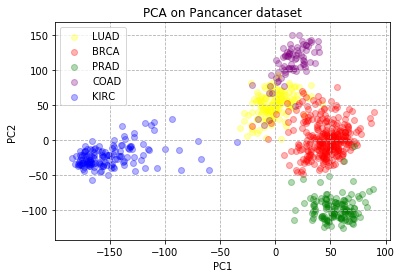

In [7]:
color_dict = {'BRCA': 'red', 'KIRC': 'blue', 'PRAD': 'green', 'LUAD': 'yellow', 'COAD':'purple'}
fig = plt.figure()

for i, label in enumerate(label_names):
    print(label)
    plt.scatter(X_PCA.numpy()[labels == label, 0], X_PCA.numpy()[labels == label, 1], label=label, color = color_dict[label], alpha=0.3)

plt.legend()
plt.title('PCA on Pancancer dataset')
plt.grid(linestyle='--')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show();

In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_PCA.numpy(), labels, test_size = 0.30)
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))
y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

SVM train accuracy: 0.9535714285714286
[[97  0  0  1  3]
 [ 0 18  0  3  0]
 [ 0  0 41  0  0]
 [ 3  0  0 34  0]
 [ 1  0  0  0 40]]
              precision    recall  f1-score   support

        BRCA       0.96      0.96      0.96       101
        COAD       1.00      0.86      0.92        21
        KIRC       1.00      1.00      1.00        41
        LUAD       0.89      0.92      0.91        37
        PRAD       0.93      0.98      0.95        41

    accuracy                           0.95       241
   macro avg       0.96      0.94      0.95       241
weighted avg       0.96      0.95      0.95       241

SVM test accuracy: 0.9543568464730291


## 2. Decisiton Tree and Gradient Boosting

In [1]:
import csv
import numpy as np
import sys, os, pdb
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import time

## Decision Tree

In [14]:
if True: # PCA1000
    with open('pca1000.pickle', 'rb') as handle:
        dataset = pickle.load(handle)
    data_train = dataset['data_train']
    data_test = dataset['data_test']
    label_train = dataset['label_train']
    label_test = dataset['label_test']
if False: # Origianl
    with open("../data/tumor-type-core.pkl", 'rb') as f:
        data = pickle.load(f)

    labels = data['label']
    data = data['data']

    data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size = 0.30)

X_train, X_test, y_train, y_test = data_train, data_test, label_train, label_test

### Origianl Data

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.913


### PCA-1000

In [9]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.820


## GBoost

### Original data

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# X_train, X_test, y_train, y_test = train_test_split(
#     X_data, Y_data, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.951


### PCA-1000

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# X_train, X_test, y_train, y_test = train_test_split(
#     X_data, Y_data, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.927


## 3. Dimension Reduction and SVM

## Load Data

In [2]:
import csv
import numpy as np
import sys, os, pdb
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

with open("../data/tumor-type-core.pkl", 'rb') as f:
    data = pickle.load(f)

labels = data['label']
data = data['data']

print("Original data dimension:{}".format(data.shape))
label_names = list(set(labels))
print("Labels:{}".format(label_names))

Original data dimension:(5238, 20531)
Labels:[b'KIRC', b'LAML', b'COAD', b'BLCA', b'GBM', b'HNSC', b'LUAD', b'BRCA', b'READ', b'LUSC', b'UCEC', b'OV']


## PCA from 20k to 10

b'KIRC'
b'LAML'
b'COAD'
b'BLCA'
b'GBM'
b'HNSC'
b'LUAD'
b'BRCA'
b'READ'
b'LUSC'
b'UCEC'
b'OV'


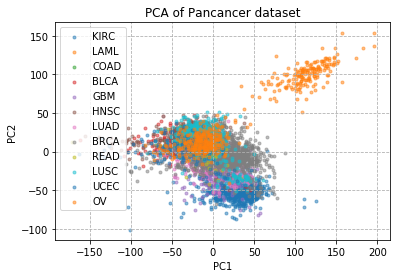

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_norm = StandardScaler().fit_transform(data)
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(data_norm)

# make pca plot
# color_dict = {b'BRCA': 'red', b'KIRC': 'blue', b'PRAD': 'green', \
#               b'LUAD': 'yellow', b'COAD':'purple'}
c = np.random.randint(1, 5, size=len(label_names))

fig = plt.figure()
for i, label in enumerate(label_names):
    print(label)
    plt.scatter(X_PCA[labels == label, 0], X_PCA[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(linestyle='--')
plt.title('PCA of Pancancer dataset')
plt.show();
fig.savefig("pca_larger.png", dpi=fig.dpi)

## SVM on raw data (20k)

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import time

start_time = time.time()
print("Training SVM")
# X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

print("Training time: {} sec".format(time.time() - start_time))

start_time = time.time()
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))

y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

print("Evaluation time: {} sec".format(time.time() - start_time))

Training SVM
Training time: 59.22136640548706 sec
SVM train accuracy: 1.0
[[118   1   0   1   1   0   0   0   3   0   0   1]
 [  4 346   1   1   0   0   0   0   0   0   0   1]
 [  2   0  67   0   0   0   0   0   0   0  18   0]
 [  0   0   0  57   0   0   0   0   0   0   0   0]
 [  5   1   0   0 173   0   0   0   4   0   0   0]
 [  2   0   0   0   0 187   0   0   0   0   0   1]
 [  0   0   0   0   0   0  54   0   0   0   0   0]
 [  0   1   1   0   0   1   0 145   9   0   0   0]
 [  5   3   0   0   3   0   0  13 140   0   0   1]
 [  0   0   0   1   0   0   0   0   0 107   0   0]
 [  0   0  19   0   0   0   0   0   0   0  14   0]
 [  2   0   0   1   0   0   0   0   1   0   0  56]]
              precision    recall  f1-score   support

     b'BLCA'       0.86      0.94      0.90       125
     b'BRCA'       0.98      0.98      0.98       353
     b'COAD'       0.76      0.77      0.77        87
      b'GBM'       0.93      1.00      0.97        57
     b'HNSC'       0.98      0.95      0.9

## Accuracy v.s. PC number

In [4]:
# acc v.s. pc number
train_acc_list = []
test_acc_list = []
for i in range(1, 11):
    print("Training SVM on {} principal components".format(i))
    X_train, X_test, y_train, y_test = train_test_split(X_PCA[:, 0:i], labels, test_size = 0.30)
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)

    y_pred_train = svclassifier.predict(X_train)
    acc = (y_pred_train == y_train).sum() / y_train.shape[0]
    print("SVM train accuracy: {}".format(acc))
    train_acc_list.append(acc)

    y_pred = svclassifier.predict(X_test)
    acc = (y_pred == y_test).sum() / y_test.shape[0]
    print("SVM test accuracy: {}".format(acc))
    test_acc_list.append(acc)

print("Training acc:", train_acc_list)
print("Test acc: ", test_acc_list)

Training SVM on 1 principal components
SVM train accuracy: 0.2956901254773595
SVM test accuracy: 0.2875318066157761
Training SVM on 2 principal components
SVM train accuracy: 0.4348063284233497
SVM test accuracy: 0.43320610687022904
Training SVM on 3 principal components
SVM train accuracy: 0.574468085106383
SVM test accuracy: 0.522264631043257
Training SVM on 4 principal components
SVM train accuracy: 0.6721222040370977
SVM test accuracy: 0.6463104325699746
Training SVM on 5 principal components
SVM train accuracy: 0.759683578832515
SVM test accuracy: 0.7506361323155216
Training SVM on 6 principal components
SVM train accuracy: 0.7885979268957992
SVM test accuracy: 0.7639949109414759
Training SVM on 7 principal components
SVM train accuracy: 0.8336061102018549
SVM test accuracy: 0.8295165394402035
Training SVM on 8 principal components
SVM train accuracy: 0.8603382433169667
SVM test accuracy: 0.8479643765903307
Training SVM on 9 principal components
SVM train accuracy: 0.8870703764320

(0, 1)

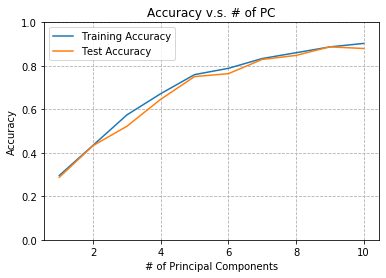

In [5]:
fig = plt.figure()
plt.plot(list(range(1,11)), train_acc_list, label="Training Accuracy")
plt.plot(list(range(1,11)), test_acc_list, label="Test Accuracy")
plt.title("Accuracy v.s. # of PC")
plt.xlabel("# of Principal Components")
plt.ylabel("Accuracy")
plt.grid(linestyle='--')
plt.legend()
plt.ylim(0, 1)

## Draw confusion matrix

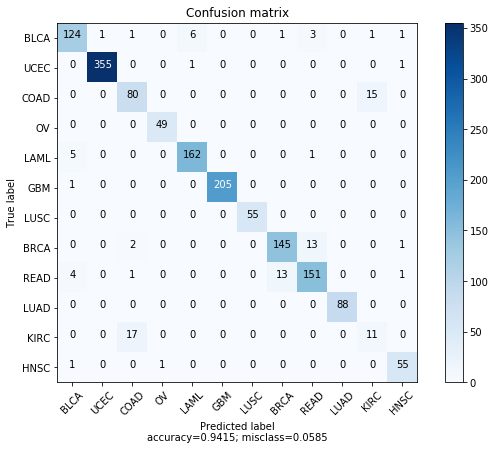

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    plt.ylim(len(target_names) - 0.5, -0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# fig = plt.figure(figsize=(10,20))
plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names=[str(label, 'utf-8') for label in label_names], normalize=False)

## t-SNE
Because t-SNE is computationally heavy, it is recommended to use t-SNE after PCA. First reducing feature dimension using PCA to a reasonable amount (like 10, which still can't seperate the data clusters), and then apply t-SNE on the feature-dimension-reduced data. 

On the other hand, t-SNE can only be applied to thousands of samples in practive. Because its complexity scales quadratically with the quantity of data (not feature). 

## t-SNE on raw data (20k features)

In [5]:
from sklearn.manifold import TSNE

# t-SNE on raw data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data) # or X_PCA
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5238 samples in 3.738s...
[t-SNE] Computed neighbors for 5238 samples in 677.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5238
[t-SNE] Computed conditional probabilities for sample 2000 / 5238
[t-SNE] Computed conditional probabilities for sample 3000 / 5238
[t-SNE] Computed conditional probabilities for sample 4000 / 5238
[t-SNE] Computed conditional probabilities for sample 5000 / 5238
[t-SNE] Computed conditional probabilities for sample 5238 / 5238
[t-SNE] Mean sigma: 98386.101132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.601997
[t-SNE] KL divergence after 300 iterations: 1.952452
t-SNE done! Time elapsed: 690.9133279323578 seconds


Text(0, 0.5, 't-SNE 2')

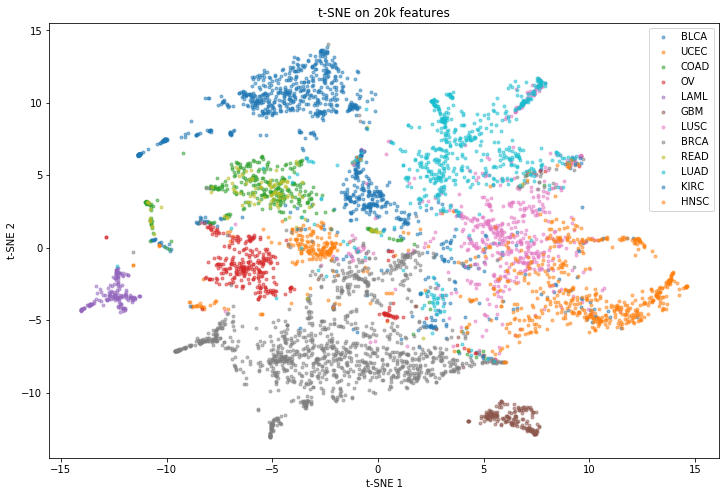

In [11]:
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    plt.scatter(
        tsne_results[labels == label, 0], 
        tsne_results[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.5
    )
plt.legend()
plt.title("t-SNE on 20k features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

## t-SNE on PCA (10) data

In [7]:
time_start = time.time()
pca_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
pca_tsne_results = tsne.fit_transform(X_PCA) # or data
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5238 samples in 0.002s...
[t-SNE] Computed neighbors for 5238 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5238
[t-SNE] Computed conditional probabilities for sample 2000 / 5238
[t-SNE] Computed conditional probabilities for sample 3000 / 5238
[t-SNE] Computed conditional probabilities for sample 4000 / 5238
[t-SNE] Computed conditional probabilities for sample 5000 / 5238
[t-SNE] Computed conditional probabilities for sample 5238 / 5238
[t-SNE] Mean sigma: 8.742022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.159973
[t-SNE] KL divergence after 300 iterations: 1.892745
t-SNE done! Time elapsed: 9.289610624313354 seconds


Text(0, 0.5, 't-SNE 2')

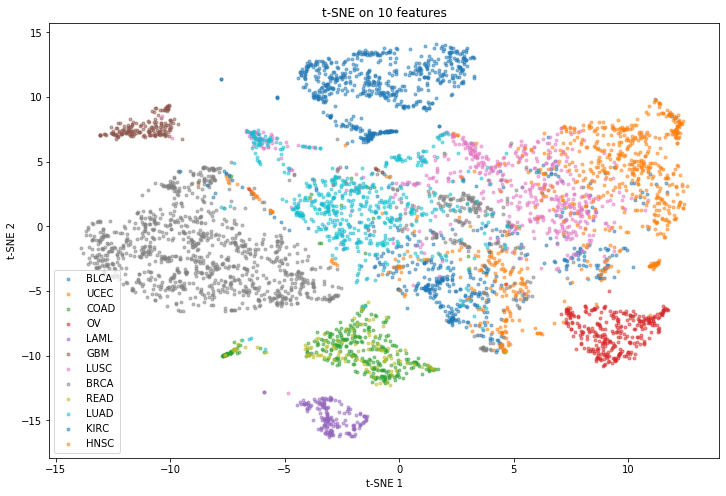

In [13]:
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    plt.scatter(
        pca_tsne_results[labels == label, 0], 
        pca_tsne_results[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.5
    )
plt.legend()
plt.title("t-SNE on 10 features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

## Comparison between PCA with/without t-SNE

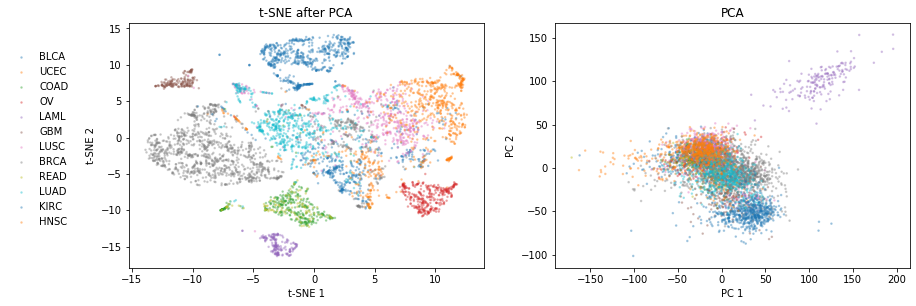

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(14,4.5))
s = [10 for n in range(len(pca_tsne_results))]
for i, label in enumerate(label_names):
    axs[0].scatter(
        pca_tsne_results[labels == label, 0], 
        pca_tsne_results[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.3, s=s)
axs[0].set_title("t-SNE after PCA")
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")
axs[0].legend(loc='upper center', bbox_to_anchor=(-0.25, 0.9), ncol=1, borderaxespad=0, frameon=False)

s = [10 for n in range(len(X_PCA))]
for i, label in enumerate(label_names):
    axs[1].scatter(
        X_PCA[labels == label, 0], 
        X_PCA[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.3, s=s)
axs[1].set_title("PCA")
axs[1].set_xlabel("PC 1")
axs[1].set_ylabel("PC 2")
# axs[1].legend(loc='upper center', bbox_to_anchor=(1.2, 0.7), ncol=1, borderaxespad=0, frameon=False)

plt.show()

## Training SVM on t-SNE (3) after PCA (10)

In [93]:
# t-SNE on pca data (10 -> 10)
time_start = time.time()
pca_tsne3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
pca_tsne3_results = tsne.fit_transform(X_PCA) # or X_PCA
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5238 samples in 0.002s...
[t-SNE] Computed neighbors for 5238 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5238
[t-SNE] Computed conditional probabilities for sample 2000 / 5238
[t-SNE] Computed conditional probabilities for sample 3000 / 5238
[t-SNE] Computed conditional probabilities for sample 4000 / 5238
[t-SNE] Computed conditional probabilities for sample 5000 / 5238
[t-SNE] Computed conditional probabilities for sample 5238 / 5238
[t-SNE] Mean sigma: 8.742022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.275993
[t-SNE] KL divergence after 300 iterations: 1.635480
t-SNE done! Time elapsed: 35.12287139892578 seconds


In [94]:
start_time = time.time()
print("Training SVM")
# X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
X_train, X_test, y_train, y_test = train_test_split(pca_tsne3_results, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

print("Training time: {} sec".format(time.time() - start_time))

start_time = time.time()
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))

y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

print("Evaluation time: {} sec".format(time.time() - start_time))

Training SVM
Training time: 0.11798548698425293 sec
SVM train accuracy: 0.8074195308237861
[[ 83  11   0   0   7   0   0   9   5   0   0   6]
 [ 12 310   0   0   1   0   0   8  10   0   0   8]
 [  0   1 100   0   0   0   0   4   1   0   0   0]
 [  0   0   0  57   0   0   0   0   3   0   0   0]
 [ 16   2   0   0 136   0   0   3  24   0   0   6]
 [  0   2   0   0   0 188   0   0   2   0   0   1]
 [  0   0   1   0   0   0  41   0   0   0   0   0]
 [  8  14   1   0   0   0   0 133  17   0   0   1]
 [  5   3   0   2  27   1   0  23 107   0   0   0]
 [  0   1   0   0   0   0   0   0   0  89   0   0]
 [  0   0  27   0   0   0   0   0   0   0   0   0]
 [  8  32   0   0   0   0   0   1   0   2   0  12]]
              precision    recall  f1-score   support

     b'BLCA'       0.63      0.69      0.66       121
     b'BRCA'       0.82      0.89      0.86       349
     b'COAD'       0.78      0.94      0.85       106
      b'GBM'       0.97      0.95      0.96        60
     b'HNSC'       0.80  

/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Re-do PCA (1000), to have higher cumulateive variation

In [10]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(data_norm)
print('Cumulative explained variation for 1000 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
X_PCA = pca.fit_transform(data_norm)
print(X_PCA.shape)

Cumulative explained variation for 1000 principal components: 0.11726336548945943
(5238, 2)


## Re-train SVM on PCA (1000)

In [11]:
start_time = time.time()
print("Training SVM")
# X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

print("Training time: {} sec".format(time.time() - start_time))

start_time = time.time()
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))

y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

print("Evaluation time: {} sec".format(time.time() - start_time))
plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names=[str(label, 'utf-8') for label in label_names], normalize=False)

Training SVM
Training time: 162.88603806495667 sec
SVM train accuracy: 0.44244408074195307
[[ 18  16   0   0  83   1   0   0   8   0   0   0]
 [ 11 287   0   0  24  13   0   0  29   0   0   0]
 [  6  31   0   0  50   1   0   0  12   0   0   0]
 [  0  24   0  10   0  15   0   0   0   0   0   0]
 [  5  26   0   0  90   0   0   0  31   0   0   0]
 [  0  14   0   6   0 158   0   0   0   0   0   0]
 [  0   0   0   0   0   0  47   0   0   0   0   0]
 [  4 136   0   3  11  14   0   0  14   0   0   0]
 [  3  37   0   1  77  13   0   0  45   0   0   0]
 [  8  47   0   0  20   1   0   0  22   0   0   0]
 [  1  15   0   1  10   0   0   0   5   0   0   0]
 [ 15  23   0   1  21   4   0   0   4   0   0   0]]
              precision    recall  f1-score   support

     b'BLCA'       0.25      0.14      0.18       126
     b'BRCA'       0.44      0.79      0.56       364
     b'COAD'       0.00      0.00      0.00       100
      b'GBM'       0.45      0.20      0.28        49
     b'HNSC'       0.23  

/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'plot_confusion_matrix' is not defined

## t-SNE (2) on PCA (1000)

In [104]:
# t-SNE on pca-1000 data
time_start = time.time()
pca_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
pca_tsne_results = tsne.fit_transform(X_PCA) # or data
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5238 samples in 0.078s...
[t-SNE] Computed neighbors for 5238 samples in 36.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5238
[t-SNE] Computed conditional probabilities for sample 2000 / 5238
[t-SNE] Computed conditional probabilities for sample 3000 / 5238
[t-SNE] Computed conditional probabilities for sample 4000 / 5238
[t-SNE] Computed conditional probabilities for sample 5000 / 5238
[t-SNE] Computed conditional probabilities for sample 5238 / 5238
[t-SNE] Mean sigma: 27.157516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.865097
[t-SNE] KL divergence after 300 iterations: 1.779956
t-SNE done! Time elapsed: 81.3588273525238 seconds


Text(0, 0.5, 't-SNE 2')

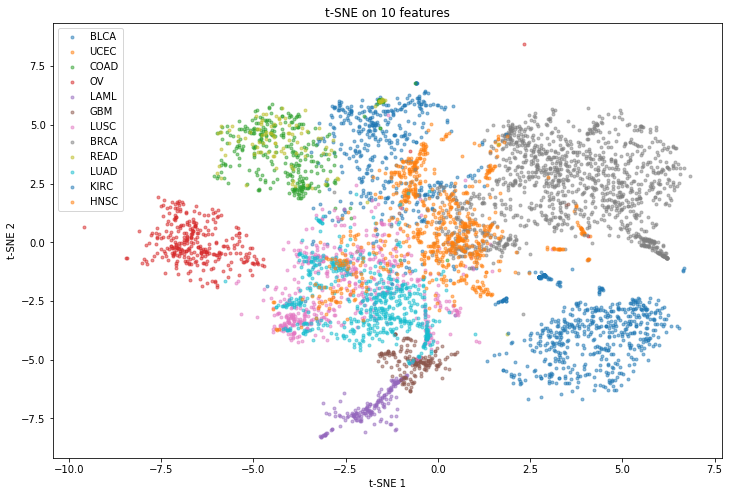

In [105]:
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    plt.scatter(
        pca_tsne_results[labels == label, 0], 
        pca_tsne_results[labels == label, 1], label=str(label, 'utf-8'), cmap="Spectral", marker='.', alpha=0.5
    )
plt.legend()
plt.title("t-SNE on 10 features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

## Re-train SVM on t-SNE (2) from PCA (1000)

In [107]:
start_time = time.time()
print("Training SVM")
# X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
X_train, X_test, y_train, y_test = train_test_split(pca_tsne_results, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

print("Training time: {} sec".format(time.time() - start_time))

start_time = time.time()
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))

y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

print("Evaluation time: {} sec".format(time.time() - start_time))

Training SVM
Training time: 0.061486005783081055 sec
SVM train accuracy: 0.9173486088379705
[[118   2   1   0   6   0   0   2   4   0   0   0]
 [  2 334   0   1   1   0   0   0   1   0   0   0]
 [  3   0  91   0   0   0   0   2   1   0   0   0]
 [  0   0   0  50   0   0   0   0   0   0   0   0]
 [  3   1   0   0 158   0   0   2  20   0   0   0]
 [  0   0   0   0   2 183   0   3   0   0   0   0]
 [  0   0   0   0   0   0  61   0   0   0   0   0]
 [  1   0   0   0   0   0   0 160   8   0   0   0]
 [  4   0   0   0   7   0   0  30 132   0   0   0]
 [  0   0   0   0   0   0   0   0   0  94   0   0]
 [  0   0  34   0   0   1   0   0   0   0   0   0]
 [  1   8   0   0   0   0   0   0   0   0   0  40]]
              precision    recall  f1-score   support

     b'BLCA'       0.89      0.89      0.89       133
     b'BRCA'       0.97      0.99      0.98       339
     b'COAD'       0.72      0.94      0.82        97
      b'GBM'       0.98      1.00      0.99        50
     b'HNSC'       0.91 

/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Re-train SVM on t-SNE (3) on PCA (1000) data

In [109]:
# t-SNE on pca-1000 data
time_start = time.time()
pca_tsne3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
pca_tsne3_results = tsne.fit_transform(X_PCA) # or data
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

start_time = time.time()
print("Training SVM")
# X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
X_train, X_test, y_train, y_test = train_test_split(pca_tsne3_results, labels, test_size = 0.30)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

print("Training time: {} sec".format(time.time() - start_time))

start_time = time.time()
y_pred_train = svclassifier.predict(X_train)
acc = (y_pred_train == y_train).sum() / y_train.shape[0]
print("SVM train accuracy: {}".format(acc))

y_pred = svclassifier.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# sklearn.metrics.plot_confusion_matrix(svclassifier, X_test, y_test,
#                                  display_labels=label_names,
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')

acc = (y_pred == y_test).sum() / y_test.shape[0]
print("SVM test accuracy: {}".format(acc))

print("Evaluation time: {} sec".format(time.time() - start_time))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5238 samples in 0.078s...
[t-SNE] Computed neighbors for 5238 samples in 36.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5238
[t-SNE] Computed conditional probabilities for sample 2000 / 5238
[t-SNE] Computed conditional probabilities for sample 3000 / 5238
[t-SNE] Computed conditional probabilities for sample 4000 / 5238
[t-SNE] Computed conditional probabilities for sample 5000 / 5238
[t-SNE] Computed conditional probabilities for sample 5238 / 5238
[t-SNE] Mean sigma: 27.339245
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.931053
[t-SNE] KL divergence after 300 iterations: 1.772064
t-SNE done! Time elapsed: 75.86926531791687 seconds
Training SVM
Training time: 0.06289172172546387 sec
SVM train accuracy: 0.908619749045281
[[110   3   0   0   6   1   0   0   4   0   0   1]
 [  1 361   0   0   0   1   0   0   1   0   0   2]
 [  0   1  84   0   0   0   0   1   0   0   0   0]
 [  0

/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusions
__Hyper-parameter selection__: PCA-1000, (not necessary: tSNE-3)

PCA-1000 (features) improves the accuracy compared to original 20k-feature data from 94% to 95%. t-SNE(2) makes the data more visually seperable, but t-SNE(3) decrease the SVM's test accuracy from 95% to 92%. Dimension reduction tricks also significantly reduces the SVM processing time (1000 times).

I also noticed that PCA-10 doesn't have enough representation power for our data, by looking at the cumulative explained variance (0.3 of the original variance), while PCA-1000 has fairly enough representation power (0.8 of the origianl varaince).

## Save PCA-1000 features to files

In [111]:
import pickle
X_train, X_test, y_train, y_test = train_test_split(X_PCA, labels, test_size = 0.30)
dic = {'data_train': X_train, 'data_test': X_test, 'label_train': y_train, 'label_test': y_test}
with open('pca1000.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Logistic Regression and Neural Network

In [26]:
import csv
import numpy as np
import sys, os, pdb
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import time

## Logistic Regression

### PCA-1000

In [2]:
with open('pca1000.pickle', 'rb') as handle:
    dataset = pickle.load(handle)
data_train = dataset['data_train']
data_test = dataset['data_test']
label_train = dataset['label_train']
label_test = dataset['label_test']
print(label_train)

[b'UCEC' b'LAML' b'GBM' ... b'BRCA' b'LUSC' b'KIRC']


In [3]:
clf = LogisticRegression(solver='lbfgs', random_state=0, max_iter=500, multi_class='auto').fit(data_train, label_train)
pred = clf.predict(data_train)
print("Training accuracy: {}".format((pred == label_train).sum() / len(pred)))

Training accuracy: 1.0


/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [4]:
pred = clf.predict(data_test)
print("Test accuracy: {}".format((pred == label_test).sum() / len(pred)))

Test accuracy: 0.9465648854961832


### Original data

In [5]:
with open("../data/tumor-type-core.pkl", 'rb') as f:
    data = pickle.load(f)

labels = data['label']
data = data['data']

data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size = 0.30)

In [6]:
clf = LogisticRegression(solver='lbfgs', random_state=0, max_iter=500, multi_class='auto').fit(data_train, label_train)
pred = clf.predict(data_train)
print("Training accuracy: {}".format((pred == label_train).sum() / len(pred)))

Training accuracy: 1.0


/home/junzel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [7]:
pred = clf.predict(data_test)
print("Test accuracy: {}".format((pred == label_test).sum() / len(pred)))

Test accuracy: 0.9344783715012722


## MLP

### PCA-1000 data

In [37]:
with open('pca1000.pickle', 'rb') as handle:
    dataset = pickle.load(handle)
data_train = dataset['data_train']
data_test = dataset['data_test']
label_train = dataset['label_train']
label_test = dataset['label_test']

start_time = time.time()

# 10, 5 is the best parameter selection
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, \
                    hidden_layer_sizes=(10, 5), random_state=1, max_iter=500)
clf.fit(data_train, label_train)

print("Training time: {} sec".format(time.time() - start_time))

pred = clf.predict(data_train)
print("Training accuracy: {}".format((pred == label_train).sum() / len(pred)))
pred = clf.predict(data_test)
print("Test accuracy: {}".format((pred == label_test).sum() / len(pred)))

Training time: 2.3525185585021973 sec
Training accuracy: 0.9997272231314784
Test accuracy: 0.9243002544529262


[[137   0   0   0   0   0   0   0   9   1   1   1]
 [  0 365   0   0   1   0   2   1   0   0   0   3]
 [  2   0  79   3   0   0   0   1   1   1  17   0]
 [  0   0   0  58   0   0   0   0   0   1   0   1]
 [  2   1   0   0 150   0   0   0   7   0   1   0]
 [  1   0   1   0   0 171   0   2   0   2   0   0]
 [  0   0   0   0   0   0  63   1   0   0   0   0]
 [  1   0   0   0   0   0   0 151  15   0   0   1]
 [  1   0   0   0   0   0   1  12 135   0   0   0]
 [  0   0   0   3   0   1   0   0   0  84   0   0]
 [  0   0  14   0   0   0   0   1   0   0  11   0]
 [  0   0   1   0   0   3   0   0   0   1   0  49]]


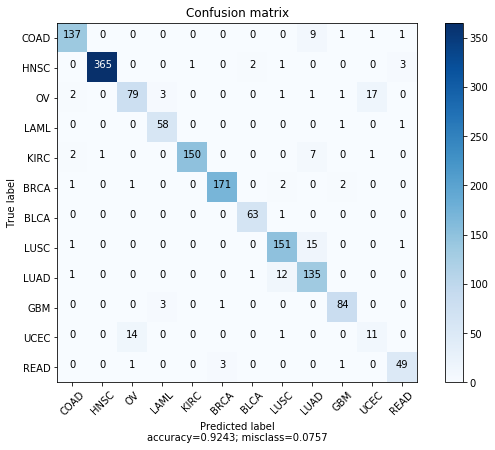

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(label_test,pred))
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    plt.ylim(len(target_names) - 0.5, -0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# fig = plt.figure(figsize=(10,20))
label_names = list(set(label_test))
plot_confusion_matrix(confusion_matrix(label_test,pred), target_names=[str(label, 'utf-8') for label in label_names], normalize=False)

### Origianl data

In [31]:
with open("../data/tumor-type-core.pkl", 'rb') as f:
    data = pickle.load(f)

labels = data['label']
data = data['data']

data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size = 0.30)

start_time = time.time()

clf = MLPClassifier(solver='adam', alpha=1e-5, \
                    hidden_layer_sizes=(50, 10), random_state=1, max_iter=500)
clf.fit(data_train, label_train)

print("Training time: {} sec".format(time.time() - start_time))

pred = clf.predict(data_train)
print("Training accuracy: {}".format((pred == label_train).sum() / len(pred)))
pred = clf.predict(data_test)
print("Test accuracy: {}".format((pred == label_test).sum() / len(pred)))

Training time: 43.70168852806091 sec
Training accuracy: 0.2337697763229678
Test accuracy: 0.2296437659033079


### Hyper-parameter scan

In [10]:
training_acc_list = []
test_acc_list = []
def train_mlp(data_train, data_test, label_train, label_test, layers=[1, 5, 8, 10, 15], nodes=[10]):
    """Train multiple layer perceptron with different hyperparameter settings"""
    for layer in layers:
        for node in nodes:
            clf = MLPClassifier(solver='adam', alpha=1e-5, \
                    hidden_layer_sizes=(node, layer), random_state=1, max_iter=500)
            clf.fit(data_train, label_train)
            pred = clf.predict(data_train)
            training_acc = (pred == label_train).sum() / len(pred)
            print("Training accuracy: {}".format(training_acc))
            training_acc_list.append(training_acc)
            
            pred = clf.predict(data_test)
            test_acc = (pred == label_test).sum() / len(pred)
            print("Test accuracy: {}".format(test_acc))
            test_acc_list.append(test_acc)
train_mlp(data_train, data_test, label_train, label_test)

Training accuracy: 0.5556464811783961
Test accuracy: 0.5108142493638677
Training accuracy: 0.9983633387888707
Test accuracy: 0.9255725190839694
Training accuracy: 0.9978177850518276
Test accuracy: 0.916030534351145
Training accuracy: 0.9972722313147845
Test accuracy: 0.9223918575063613
Training accuracy: 0.9989088925259137
Test accuracy: 0.9185750636132316


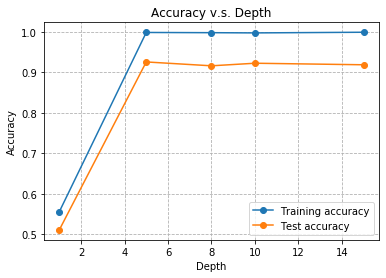

In [11]:
fig = plt.figure()
plt.plot([1, 5, 8, 10, 15], training_acc_list, marker='o', label='Training accuracy')
plt.plot([1, 5, 8, 10, 15], test_acc_list, marker='o', label='Test accuracy')
plt.legend()
plt.title("Accuracy v.s. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.grid(linestyle='--')

In [ ]:
nodes = [3, 5, 10, 50, 100]
training_acc_list = []
test_acc_list = []
train_mlp(data_train, data_test, label_train, label_test, layers = [5], nodes=nodes)

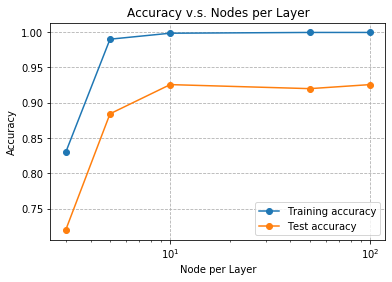

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(nodes, training_acc_list, marker='o', label='Training accuracy')
ax.plot(nodes, test_acc_list, marker='o', label='Test accuracy')
plt.legend()
ax.set_title("Accuracy v.s. Nodes per Layer")
ax.set_xscale('log')
ax.set_xlabel("Node per Layer")
ax.set_ylabel("Accuracy")
plt.grid(linestyle='--')

## Conclusion
MLP has good performance. From the hyperparameter scan, the optimal setting is 5 layers and 10 nodes per layer.